## Install dependencies

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

## Import dependencies

In [3]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
env = gym.make('Taxi-v3')
obs = env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
obs

373

In [6]:
print('Observation Space {}'.format(env.observation_space))
print('Observation sample {}'.format(env.observation_space.sample()))
print('Action space {}'.format(env.action_space))
print('Action sample {}'.format(env.action_space.sample()))

Observation Space Discrete(500)
Observation sample 466
Action space Discrete(6)
Action sample 3


In [7]:
next_obs, r, done, _ = env.step(2) 
print(next_obs, r, done)
env.render()

393 -1 False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


In [8]:
state_size = env.observation_space.n
action_size = env.action_space.n

print('State size = {}'.format(state_size))
print('Action size = {}'.format(action_size))

State size = 500
Action size = 6


# Create stochastic tabular policy

$$ policy[state, action] = P(action | state)$$

In [9]:
policy = np.full((state_size, action_size), 1./action_size)


In [10]:
policy

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

## Make rollout


In [11]:


def rollout(env, policy, t_max=10**4):
  states, actions = [], []
  rollout_reward = 0
  s = env.reset()
  
  for t in range(t_max):
    

    a = np.random.choice(np.arange(action_size), p = policy[s])
    
    next_s, r, done, info = env.step(a)
    
    states.append(s)
    actions.append(a)
    rollout_reward += r
    
    s = next_s
    if done: 
      break
      
  return states, actions, rollout_reward

In [12]:
s, a, r = rollout(env, policy)

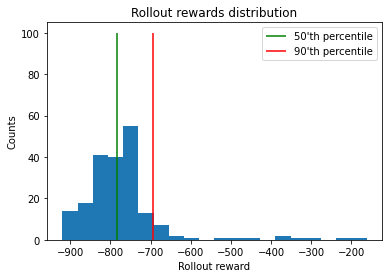

In [13]:
sample_rewards = [rollout(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [
           100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [
           100], label="90'th percentile", color='red')
plt.xlabel('Rollout reward')
plt.ylabel('Counts')
plt.title('Rollout rewards distribution')
plt.legend();

## Crossentropy method steps



In [14]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50): 
  
  reward_threshold =  np.percentile(rewards_batch, q=percentile)
  
  best_states = []
  best_actions = []
  
  
  for t, r in enumerate(rewards_batch):
    if (r >= reward_threshold):
      best_states.extend(states_batch[t])
      best_actions.extend(actions_batch[t])
  
  return best_states, best_actions

In [15]:


states_batch = [
    [1, 2, 3],  
    [4, 2, 0, 2],  
    [3, 1]  
]

actions_batch = [
    [0, 2, 4],  
    [3, 2, 0, 1],  
    [3, 3]  
]
rewards_batch = [
    3,  
    4,  
    5,  
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [16]:
def update_policy(best_states, best_actions):
  """
  Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
  """
  new_policy = np.zeros([state_size, action_size])
  
  

  occurences = {}
    
  for idx in range(state_size):
      occurences[idx] = 0
    
  for index,state in enumerate(best_states):
      new_policy[state,best_actions[index]] += 1 
      occurences[state] += 1
      
  for idx in range(state_size):
      if occurences[idx] == 0:
          new_policy[idx,:] = 1./action_size
      else:
          new_policy[idx,:] /= occurences[idx]
  
  return new_policy

In [17]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [
                               0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

Ok!


## Train

In [18]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [19]:
policy = np.ones([state_size,action_size])/action_size

mean reward = -87.280, threshold=5.000


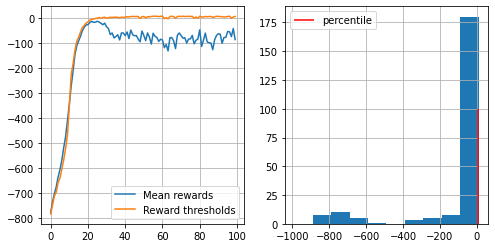

In [20]:
n_rollouts = 250  
percentile = 50  
learning_rate = 0.5  

log = []

for i in range(100):

    
    sessions =  [rollout(env,policy) for _ in range(n_rollouts)]  
   
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile) 
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate*new_policy + (1-learning_rate)*policy

    
    show_progress(rewards_batch, log)

## Visualize solution


In [21]:
s = env.reset()
done = False

while not done:
  env.render()
  a = np.random.choice(range(action_size), p=policy[s])
  s, r, done, info = env.step(a)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| :

# CEM continious action space

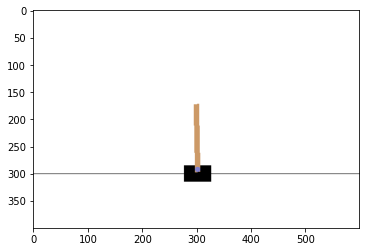

In [22]:
env = gym.make('CartPole-v0')
env.reset()
plt.imshow(env.render(mode="rgb_array"));

In [23]:
print('Observation Space {}'.format(env.observation_space))
print('Observation sample {}'.format(env.observation_space.sample()))
print('Action space {}'.format(env.action_space))
print('Action sample {}'.format(env.action_space.sample()))

Observation Space Box(4,)
Observation sample [-4.4485784e+00  3.1095650e+38  1.9531918e-01  1.3326868e+36]
Action space Discrete(2)
Action sample 1


In [24]:
action_size = env.action_space.n

print('Action size = {}'.format(action_size))

Action size = 2


In [25]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh',
                      warm_start=True,
                      max_iter=1,
                     )
agent.fit([env.reset()]*action_size, range(action_size))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

In [26]:
def agent_rollout(env, agent, t_max=10**4):
  states, actions = [], []
  rollout_reward = 0
  s = env.reset()
  
  for t in range(t_max):
    
    
    probs = agent.predict_proba([s])[0]
    
    
    a = np.random.choice(np.arange(action_size), p = probs)
    
    next_s, r, done, info = env.step(a)
    
    states.append(s)
    actions.append(a)
    rollout_reward += r
    
    s = next_s
    if done: 
      break
      
  return states, actions, rollout_reward

mean reward = 190.940, threshold=200.000


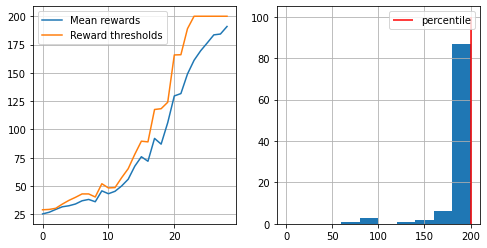

You Win! You may stop training now via KeyboardInterrupt.


In [27]:

n_rollouts = 100
percentile = 70
log = []

for i in range(100):
    
    
    
    sessions = [agent_rollout(env,agent) for _ in range(n_rollouts)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    
    agent.fit(elite_states, elite_actions)
    
    show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

## Visualize agent

In [28]:
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="./videos", force=True)
sessions = [agent_rollout(env, agent, t_max=1000) for _ in range(100)]
env.close()

In [29]:
!ls ./videos

openaigym.episode_batch.0.126.stats.json
openaigym.manifest.0.126.manifest.json
openaigym.video.0.126.video000000.meta.json
openaigym.video.0.126.video000000.mp4
openaigym.video.0.126.video000001.meta.json
openaigym.video.0.126.video000001.mp4
openaigym.video.0.126.video000008.meta.json
openaigym.video.0.126.video000008.mp4
openaigym.video.0.126.video000027.meta.json
openaigym.video.0.126.video000027.mp4
openaigym.video.0.126.video000064.meta.json
openaigym.video.0.126.video000064.mp4


In [30]:
import glob
mp4list = glob.glob('videos/*.mp4')
mp4list

['videos/openaigym.video.0.126.video000000.mp4',
 'videos/openaigym.video.0.126.video000008.mp4',
 'videos/openaigym.video.0.126.video000064.mp4',
 'videos/openaigym.video.0.126.video000001.mp4',
 'videos/openaigym.video.0.126.video000027.mp4']

In [31]:

import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML

def show_video(name):  
  if len(mp4list) > 0:
    mp4 = name
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")



In [32]:
show_video(mp4list[3])